In [4]:
# --- Cell 1: Imports & Config ---
import os, ast, math, json
import numpy as np, pandas as pd
from typing import List, Tuple, Optional
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_recall_curve,
    roc_curve,
)
import matplotlib.pyplot as plt
from tqdm import tqdm


# Pick device for Mac M1/M2
def pick_device():
    if torch.backends.mps.is_available():
        return "mps"
    return "cpu"


CFG = dict(
    esm_model="facebook/esm2_t12_35M_UR50D",  # Good balance for M1
    max_len=1024,
    batch_size=8,
    epochs=5,
    lr=2e-4,
    device=pick_device(),
    seed=42,
    num_workers=0,
    out_dir="runs_site",
)

os.makedirs(CFG["out_dir"], exist_ok=True)
torch.manual_seed(CFG["seed"])
np.random.seed(CFG["seed"])

print(f"Using device: {CFG['device']}")

Using device: mps


In [5]:
# --- Cell 2: Dataset utilities ---
CHAIN_ORDER = list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz1234")


def safe_read_csv(path):
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.read_csv(path, sep=None, engine="python", on_bad_lines="skip")


def pick_chain_cols(df: pd.DataFrame) -> Tuple[str, str]:
    for ch in ["A"] + CHAIN_ORDER:
        s_col = f"chain_{ch}_sequence"
        b_col = f"chain_{ch}_binding_array"
        if s_col in df.columns and b_col in df.columns:
            return s_col, b_col
    raise ValueError("No valid chain_*_sequence + chain_*_binding_array found")


def parse_binding_array(x):
    if isinstance(x, list):
        return x
    try:
        return list(ast.literal_eval(x))
    except Exception:
        return []


class SiteDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tok, max_len: int):
        self.tok, self.max_len = tok, max_len
        self.rows = []
        s_col, b_col = pick_chain_cols(df)
        for _, r in df.iterrows():
            seq = str(r[s_col]) if pd.notna(r[s_col]) else None
            arr = parse_binding_array(r[b_col]) if pd.notna(r[b_col]) else []
            if not seq:
                continue
            seq = seq[:max_len]
            if len(arr) < len(seq):
                arr = arr + [0] * (len(seq) - len(arr))
            arr = arr[: len(seq)]
            self.rows.append((seq, np.array(arr, dtype=np.int64)))

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, i):
        seq, y = self.rows[i]
        y = list(y)
        valid = set("ACDEFGHIKLMNPQRSTVWYBXZU")
        seq_clean, y_clean = [], []
        for c, lbl in zip(seq, y):
            cu = c.upper()
            if cu in valid:
                seq_clean.append(cu)
                y_clean.append(int(lbl))
        enc = self.tok(
            "".join(seq_clean),
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt",
        )
        input_ids = enc["input_ids"].squeeze(0)
        attn = enc["attention_mask"].squeeze(0)

        labels = torch.full_like(input_ids, -100)
        special = {self.tok.cls_token_id, self.tok.sep_token_id, self.tok.pad_token_id}
        aa_positions = [
            i for i, tid in enumerate(input_ids.tolist()) if tid not in special
        ]
        L = min(len(aa_positions), len(y_clean))
        if L > 0:
            labels[aa_positions[:L]] = torch.tensor(y_clean[:L], dtype=torch.long)
        return {"input_ids": input_ids, "attention_mask": attn, "labels": labels}

In [6]:
# --- Cell 3: Model ---
class ESMTokenSite(nn.Module):
    def __init__(self, model_name, freeze_backbone=False, n_unfrozen_layers=0):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        hidden = self.backbone.config.hidden_size
        self.classifier = nn.Linear(hidden, 1)
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
            if n_unfrozen_layers > 0 and hasattr(self.backbone, "encoder"):
                for layer in self.backbone.encoder.layer[-n_unfrozen_layers:]:
                    for p in layer.parameters():
                        p.requires_grad = True
        if hasattr(self.backbone, "gradient_checkpointing_enable"):
            self.backbone.gradient_checkpointing_enable()

    def forward(self, input_ids, attention_mask):
        x = self.backbone(
            input_ids=input_ids, attention_mask=attention_mask
        ).last_hidden_state
        return self.classifier(x).squeeze(-1)

In [7]:
# --- Cell 4: Training & Evaluation Helpers ---
def collate(batch):
    keys = batch[0].keys()
    return {k: torch.stack([b[k] for b in batch]) for k in keys}


def run_epoch(model, loader, criterion, optimizer=None):

    train = optimizer is not None
    model.train(train)
    total_loss, all_logits, all_labels = 0.0, [], []
    with torch.set_grad_enabled(train):
        for b in tqdm(loader):
            ids = b["input_ids"].to(CFG["device"])
            msk = b["attention_mask"].to(CFG["device"])
            lbl = b["labels"].to(CFG["device"])
            logits = model(ids, msk)
            mask_valid = lbl != -100
            if mask_valid.sum() == 0:
                continue
            target = lbl.masked_select(mask_valid).float()
            pred = logits.masked_select(mask_valid)
            loss = criterion(pred, target)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * target.numel()
            all_logits.append(pred.detach().cpu())
            all_labels.append(target.detach().cpu())
    if not all_labels:
        return dict(
            loss=float("nan"),
            roc_auc=float("nan"),
            pr_auc=float("nan"),
            f1=float("nan"),
        )
    y = torch.cat(all_labels).numpy()
    s = torch.cat(all_logits).numpy()
    return dict(
        loss=total_loss / max(1, len(y)),
        roc_auc=roc_auc_score(y, s),
        pr_auc=average_precision_score(y, s),
        f1=f1_score(y, (1 / (1 + np.exp(-s)) >= 0.5).astype(int)),
    )


def plot_curves(y, s, tag):
    fpr, tpr, _ = roc_curve(y, s)
    prec, rec, _ = precision_recall_curve(y, s)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "--")
    plt.title(f"ROC {tag}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    plt.figure()
    plt.plot(rec, prec)
    plt.title(f"PR {tag}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

In [8]:
# --- Cell 5: Training ---
def train_binding_site(
    train_csv, valid_csv=None, freeze_backbone=False, n_unfrozen_layers=0
):
    tok = AutoTokenizer.from_pretrained(CFG["esm_model"], do_lower_case=False)
    df_tr = safe_read_csv(train_csv)
    ds_tr_full = SiteDataset(df_tr, tok, CFG["max_len"])

    if valid_csv:
        df_va = safe_read_csv(valid_csv)
        ds_va = SiteDataset(df_va, tok, CFG["max_len"])
        ds_tr = ds_tr_full
    else:
        idx = np.arange(len(ds_tr_full))
        np.random.shuffle(idx)
        cut = int(0.9 * len(idx))
        ds_tr = torch.utils.data.Subset(ds_tr_full, idx[:cut])
        ds_va = torch.utils.data.Subset(ds_tr_full, idx[cut:])

    tr_loader = DataLoader(
        ds_tr, batch_size=CFG["batch_size"], shuffle=True, collate_fn=collate
    )
    va_loader = DataLoader(
        ds_va, batch_size=CFG["batch_size"], shuffle=False, collate_fn=collate
    )

    model = ESMTokenSite(CFG["esm_model"], freeze_backbone, n_unfrozen_layers).to(
        CFG["device"]
    )

    # class imbalance weight
    pos, neg = 1, 1
    for b in tr_loader:
        v = b["labels"]
        v = v[v != -100]
        pos += (v == 1).sum().item()
        neg += (v == 0).sum().item()
        break
    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([neg / pos], device=CFG["device"])
    )

    opt = torch.optim.AdamW(model.parameters(), lr=CFG["lr"])
    for e in range(1, CFG["epochs"] + 1):
        tr_m = run_epoch(model, tr_loader, criterion, optimizer=opt)
        va_m = run_epoch(model, va_loader, criterion)

        print(
            f"Epoch {e}: Train ROC {tr_m['roc_auc']:.3f}, Val ROC {va_m['roc_auc']:.3f}"
        )
    return model, tok

In [9]:
# --- Cell 7: Evaluation on test set ---
def evaluate_on_csv(model, tok, test_csv):
    df_te = safe_read_csv(test_csv)
    ds_te = SiteDataset(df_te, tok, CFG["max_len"])
    te_loader = DataLoader(
        ds_te, batch_size=CFG["batch_size"], shuffle=False, collate_fn=collate
    )
    model.eval()
    all_logits, all_labels = [], []
    with torch.no_grad():
        for b in tqdm(te_loader):
            ids = b["input_ids"].to(CFG["device"])
            msk = b["attention_mask"].to(CFG["device"])
            lbl = b["labels"].to(CFG["device"])
            logits = model(ids, msk)
            mask_valid = lbl != -100
            target = lbl.masked_select(mask_valid).float()
            pred = logits.masked_select(mask_valid)
            all_logits.append(pred.detach().cpu())
            all_labels.append(target.detach().cpu())
    y = torch.cat(all_labels).numpy()
    s = torch.cat(all_logits).numpy()
    print("ROC-AUC:", roc_auc_score(y, s), "PR-AUC:", average_precision_score(y, s))
    plot_curves(y, s, "Test")

In [10]:
# --- Cell 6: Training Visualization ---
def plot_training_history(history_path=None, history_dict=None):
    """Plot training and validation metrics over epochs"""
    if history_path:
        with open(history_path, "r") as f:
            history = json.load(f)
    elif history_dict:
        history = history_dict
    else:
        history_path = os.path.join(CFG["out_dir"], "training_history.json")
        try:
            with open(history_path, "r") as f:
                history = json.load(f)
        except FileNotFoundError:
            logger.error(f"No training history found at {history_path}")
            return

    epochs = history["epoch"]

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Loss plot
    ax1.plot(epochs, history["train_loss"], "b-", label="Train Loss", linewidth=2)
    ax1.plot(epochs, history["val_loss"], "r-", label="Val Loss", linewidth=2)
    ax1.set_title("Training and Validation Loss", fontsize=14, fontweight="bold")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # ROC-AUC plot
    ax2.plot(epochs, history["train_roc_auc"], "b-", label="Train ROC-AUC", linewidth=2)
    ax2.plot(epochs, history["val_roc_auc"], "r-", label="Val ROC-AUC", linewidth=2)
    ax2.set_title("ROC-AUC Score", fontsize=14, fontweight="bold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("ROC-AUC")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # PR-AUC plot
    ax3.plot(epochs, history["train_pr_auc"], "b-", label="Train PR-AUC", linewidth=2)
    ax3.plot(epochs, history["val_pr_auc"], "r-", label="Val PR-AUC", linewidth=2)
    ax3.set_title("Precision-Recall AUC", fontsize=14, fontweight="bold")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("PR-AUC")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # F1 score plot
    ax4.plot(epochs, history["train_f1"], "b-", label="Train F1", linewidth=2)
    ax4.plot(epochs, history["val_f1"], "r-", label="Val F1", linewidth=2)
    ax4.set_title("F1 Score", fontsize=14, fontweight="bold")
    ax4.set_xlabel("Epoch")
    ax4.set_ylabel("F1 Score")
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the plot
    plot_path = os.path.join(CFG["out_dir"], "training_progress.png")
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")

    plt.show()

In [11]:
# --- Cell: Prepare Train/Val/Test from threaded_binding_sites_1000.csv ---
from sklearn.model_selection import train_test_split


def prepare_site_splits(csv_path, val_size=0.1, test_size=0.1, random_state=42):
    """
    Splits threaded_binding_sites_1000.csv into train, validation, and test sets.
    Stratifies by overall binding presence to keep class balance.
    """
    df = pd.read_csv(csv_path)
    df = df.sample(n=500, random_state=random_state).reset_index(drop=True)

    # Pick chain columns automatically
    s_col, b_col = pick_chain_cols(df)

    # Binary label: whether this chain has ANY binding site
    stratify_labels = df[b_col].apply(lambda x: 1 if "1" in str(x) else 0)

    # First split: train+val vs test
    df_trainval, df_test = train_test_split(
        df, test_size=test_size, random_state=random_state, stratify=stratify_labels
    )

    # Update stratify labels for train/val split
    stratify_labels_trainval = df_trainval[b_col].apply(
        lambda x: 1 if "1" in str(x) else 0
    )

    # Second split: train vs val
    df_train, df_val = train_test_split(
        df_trainval,
        test_size=val_size / (1 - test_size),
        random_state=random_state,
        stratify=stratify_labels_trainval,
    )

    print(
        f"Train size: {len(df_train)}, Validation size: {len(df_val)}, Test size: {len(df_test)}"
    )
    return (
        df_train.reset_index(drop=True),
        df_val.reset_index(drop=True),
        df_test.reset_index(drop=True),
    )

In [9]:
# --- Cell: Run the split and save ---
train_df, val_df, test_df = prepare_site_splits(
    "/Users/alex-mac/Programming/hackathon/data/threaded_binding_sites_1000.csv",
    val_size=0.1,
    test_size=0.1,
    random_state=CFG["seed"],
)

train_df.to_csv("site_train.csv", index=False)
val_df.to_csv("site_valid.csv", index=False)
test_df.to_csv("site_test.csv", index=False)

Train size: 400, Validation size: 50, Test size: 50


/var/folders/0h/12v94v056qnbt_y3lxbm6m100000gn/T/ipykernel_12004/2953635514.py:10: DtypeWarning: Columns (277,279,280,281,283,285,286,287,289,291,292,293,295,297,298,299,301,303,304,305,307,309,310,311,313,315,316,317) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [10]:
# Train model using train & val
model, tok = train_binding_site(
    "site_train.csv", "site_valid.csv", freeze_backbone=True, n_unfrozen_layers=1
)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/49 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/esm-mps/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/esm-mps/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


Epoch 1: Train ROC 0.622, Val ROC 0.645


  0%|          | 0/49 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/esm-mps/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/esm-mps/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 7/7 [00:04<00:00,  1.60it/s]



Epoch 2: Train ROC 0.687, Val ROC 0.680


  0%|          | 0/49 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/esm-mps/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/esm-mps/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch 3: Train ROC 0.719, Val ROC 0.695


  0%|          | 0/49 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/esm-mps/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/esm-mps/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch 4: Train ROC 0.734, Val ROC 0.704


  0%|          | 0/49 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/esm-mps/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/esm-mps/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

Epoch 5: Train ROC 0.745, Val ROC 0.710


100%|██████████| 7/7 [00:04<00:00,  1.45it/s]



ROC-AUC: 0.6996168915050401 PR-AUC: 0.04839469670112565


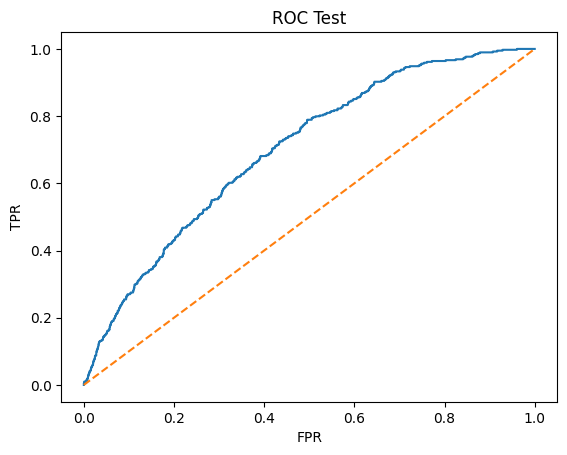

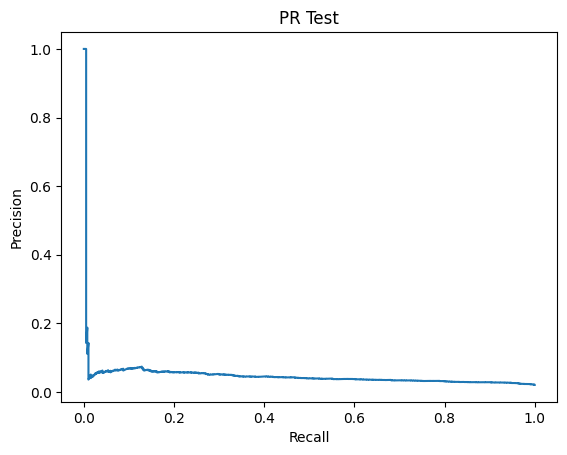

In [ ]:
evaluate_on_csv(model, tok, "site_test.csv")

In [ ]:
# --- Cell: Sequence Analysis Heatmap Visualization ---
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


def predict_sequence_binding_sites(model, tok, sequence):
    """
    Predict binding sites for a given protein sequence and return detailed results
    """
    model.eval()

    # Clean and validate sequence
    valid_aa = set("ACDEFGHIKLMNPQRSTVWYBXZU")
    sequence_clean = "".join([c.upper() for c in sequence if c.upper() in valid_aa])

    if len(sequence_clean) == 0:
        return None, None, None

    # Tokenize sequence
    enc = tok(
        sequence_clean,
        truncation=True,
        max_length=CFG["max_len"],
        padding="max_length",
        return_tensors="pt",
    )

    input_ids = enc["input_ids"].to(CFG["device"])
    attention_mask = enc["attention_mask"].to(CFG["device"])

    # Get predictions
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probabilities = torch.sigmoid(logits).cpu().numpy()[0]

    # Map predictions back to amino acids
    special_tokens = {tok.cls_token_id, tok.sep_token_id, tok.pad_token_id}
    aa_positions = [
        i for i, tid in enumerate(input_ids[0].tolist()) if tid not in special_tokens
    ]

    # Extract predictions for actual amino acid positions
    aa_predictions = []
    aa_sequence = []

    for i, pos in enumerate(aa_positions):
        if i < len(sequence_clean) and pos < len(probabilities):
            aa_predictions.append(probabilities[pos])
            aa_sequence.append(sequence_clean[i])

    return aa_sequence, aa_predictions, sequence_clean


def create_sequence_heatmap(
    model,
    tok,
    sequence,
    title="Protein Binding Site Analysis",
    figsize=(16, 8),
    threshold=0.5,
):
    """
    Create a comprehensive heatmap visualization of binding site predictions
    """
    # Get predictions
    aa_sequence, predictions, clean_sequence = predict_sequence_binding_sites(
        model, tok, sequence
    )

    if aa_sequence is None:
        print("Error: Invalid sequence or no predictions available")
        return

    # Create figure with subplots
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(4, 1, height_ratios=[1, 0.3, 0.8, 0.4], hspace=0.4)

    # 1. Main heatmap of binding probabilities
    ax1 = fig.add_subplot(gs[0])

    # Reshape data for heatmap (single row)
    heatmap_data = np.array(predictions).reshape(1, -1)

    # Create custom colormap
    colors = [
        "#000033",
        "#000066",
        "#0066cc",
        "#00ccff",
        "#66ff66",
        "#ffff00",
        "#ff6600",
        "#ff0000",
    ]
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list("binding", colors, N=n_bins)

    # Plot heatmap
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        cbar_kws={"label": "Binding Probability", "shrink": 0.8},
        xticklabels=False,
        yticklabels=["Binding Sites"],
        ax=ax1,
        vmin=0,
        vmax=1,
    )
    ax1.set_title(
        f"{title}\nSequence Length: {len(aa_sequence)} residues",
        fontsize=14,
        fontweight="bold",
        pad=20,
    )

    # 2. Amino acid sequence display
    ax2 = fig.add_subplot(gs[1])
    ax2.axis("off")

    # Color amino acids by type
    aa_colors = {
        # Hydrophobic
        "A": "#FFE4E1",
        "V": "#FFE4E1",
        "I": "#FFE4E1",
        "L": "#FFE4E1",
        "M": "#FFE4E1",
        "F": "#FFE4E1",
        "Y": "#FFE4E1",
        "W": "#FFE4E1",
        # Polar
        "S": "#E6F3FF",
        "T": "#E6F3FF",
        "N": "#E6F3FF",
        "Q": "#E6F3FF",
        "C": "#E6F3FF",
        # Charged positive
        "K": "#FFE6E6",
        "R": "#FFE6E6",
        "H": "#FFE6E6",
        # Charged negative
        "D": "#E6FFE6",
        "E": "#E6FFE6",
        # Special
        "G": "#F0F0F0",
        "P": "#F0F0F0",
    }

    for i, aa in enumerate(aa_sequence):
        color = aa_colors.get(aa, "#FFFFFF")
        ax2.text(
            i,
            0,
            aa,
            ha="center",
            va="center",
            fontsize=8,
            bbox=dict(
                boxstyle="square,pad=0.1",
                facecolor=color,
                edgecolor="black",
                linewidth=0.5,
            ),
        )

    ax2.set_xlim(-0.5, len(aa_sequence) - 0.5)
    ax2.set_ylim(-0.5, 0.5)
    ax2.set_title("Amino Acid Sequence", fontsize=12, fontweight="bold")

    # 3. Binding probability line plot
    ax3 = fig.add_subplot(gs[2])

    positions = np.arange(len(predictions))
    ax3.plot(
        positions,
        predictions,
        "b-",
        linewidth=2,
        alpha=0.7,
        label="Binding Probability",
    )
    ax3.axhline(
        y=threshold,
        color="red",
        linestyle="--",
        linewidth=2,
        alpha=0.8,
        label=f"Threshold ({threshold})",
    )

    # Highlight high-confidence binding sites
    high_conf_mask = np.array(predictions) >= threshold
    if np.any(high_conf_mask):
        ax3.scatter(
            positions[high_conf_mask],
            np.array(predictions)[high_conf_mask],
            color="red",
            s=50,
            alpha=0.8,
            zorder=5,
            label="Predicted Binding Sites",
        )

    ax3.set_xlabel("Residue Position")
    ax3.set_ylabel("Binding Probability")
    ax3.set_title("Binding Site Prediction Profile", fontsize=12, fontweight="bold")
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    ax3.set_ylim(0, 1)

    # 4. Statistics and summary
    ax4 = fig.add_subplot(gs[3])
    ax4.axis("off")

    # Calculate statistics
    mean_prob = np.mean(predictions)
    max_prob = np.max(predictions)
    n_binding_sites = np.sum(np.array(predictions) >= threshold)
    binding_percentage = (n_binding_sites / len(predictions)) * 100

    # Amino acid composition
    aa_counts = {}
    for aa in aa_sequence:
        aa_counts[aa] = aa_counts.get(aa, 0) + 1

    # Create summary text
    stats_text = f"""
    Statistics:
    • Mean binding probability: {mean_prob:.3f}
    • Maximum binding probability: {max_prob:.3f}
    • Predicted binding sites: {n_binding_sites} ({binding_percentage:.1f}%)
    • Sequence composition: {len(set(aa_sequence))} unique amino acids
    """

    # Most common amino acids
    sorted_aa = sorted(aa_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    composition_text = "Top amino acids: " + ", ".join(
        [f"{aa}({count})" for aa, count in sorted_aa]
    )

    ax4.text(
        0.02,
        0.8,
        stats_text,
        transform=ax4.transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.3),
    )
    ax4.text(
        0.02,
        0.2,
        composition_text,
        transform=ax4.transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.3),
    )

    plt.tight_layout()
    plt.show()

    # Return detailed results
    binding_sites = [
        (i, aa, prob)
        for i, (aa, prob) in enumerate(zip(aa_sequence, predictions))
        if prob >= threshold
    ]

    print(f"\nDetailed Binding Site Analysis:")
    print(f"Sequence: {clean_sequence[:50]}{'...' if len(clean_sequence) > 50 else ''}")
    print(f"Total residues analyzed: {len(aa_sequence)}")
    print(f"Predicted binding sites (≥{threshold}): {len(binding_sites)}")

    if binding_sites:
        print("\nHigh-confidence binding sites:")
        for pos, aa, prob in binding_sites[:10]:  # Show top 10
            print(f"  Position {pos+1}: {aa} (probability: {prob:.3f})")
        if len(binding_sites) > 10:
            print(f"  ... and {len(binding_sites) - 10} more")

    return {
        "sequence": clean_sequence,
        "amino_acids": aa_sequence,
        "predictions": predictions,
        "binding_sites": binding_sites,
        "statistics": {
            "mean_probability": mean_prob,
            "max_probability": max_prob,
            "n_binding_sites": n_binding_sites,
            "binding_percentage": binding_percentage,
        },
    }

In [12]:
# --- Cell: Demonstrate Heatmap with Example Sequences ---

# Example 1: Use a sequence from our test data
print("=== Example 1: Real protein sequence from test data ===")
if len(test_df) > 0:
    s_col, b_col = pick_chain_cols(test_df)
    example_sequence = test_df.iloc[0][s_col]
    example_binding = test_df.iloc[0][b_col]

    print(f"True binding array: {str(example_binding)[:100]}...")
    result1 = create_sequence_heatmap(
        model,
        tok,
        example_sequence,
        title="Real Protein Sequence - Binding Site Prediction",
        threshold=0.3,
    )

print("\n" + "=" * 80 + "\n")

# Example 2: Synthetic sequence rich in binding-prone amino acids
print("=== Example 2: Synthetic sequence with potential binding sites ===")
synthetic_sequence = "MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLSGAEKAVQVKVKALPDAQFEVVHSLAKWKRQTLGQHDFSAGEGLYTHMKALRPDEDRLSPLHSVYVDQWDWERVMGDGERQFSTLKSTVEAIWAGIKATEAAVSEEFGLAPFLPDQIHFVHSQELLSRYPDLDAKGRERAIAKDLGAVFLVGIGGKLSDGHRHDVRAPDYDDWUNIAFQELGQWVSQPLLPLPVVDDQYSLLQDVEGTCGHTVWKMYVSITLLDHGQAPFLLSQDDAFIIKNGDEKRLLPLQKYKHHMWPQQVKGLVIERLYYVEEWKSASNGDTQDNTTGALLAAGNDRHHLYVKYMFEPQRVHQNMCASILGPSYLGYLVWLWRGMAKTVKGSLGAELLGKHFDKLKRVLQMQPKEKVVHRRPKHLQYKKGVFDDSFYSADNDQDYSGRMFHYQVRFQSHYAIRYEYQHLIRQTQDIIVTSYDWYCSPQPNPTMRIQAYHGQHKLQMIHVKLHFGSGSEDVLQNLEAYQELQKRVHNVFWGKEVWVTLVLDLLLTYFRWQGVQAWKQFGVVNYCDYLRHRMTCDLRQQLNFGWYGLGWFTWLYLVLFAEIQKLVRLTRDLLISQPQTWRSEYGQWEVQASWLSAGAALFQMTNLVWAMSGKQYCSGVGVYHYSSWGWGGLFQYDKGDLSLRLGRIYAYVTHFLGEYREIVQNRYEGEIHYKCDLKYERSWYHAKGGEFPTEPFTHVIQTDKLNLVKMKMYLGRHIMQKIMGTTYHSFFQHRDGLYFKNHKNLMFRGHFKGSYICCGNRTGQWKACMWSRDLKTYNWAEHGIWTKGEGHQYQGQFHVSKDLAYQWNPFLLGKKFGFDYWQVWLQINQGYFSAPYPMGQPLHFIHCQPSWEHFKGCTQGWYVIYAYQGWGKYNNRGHFDIWNCIWLWWFFSLSCWNLDRSKFYGQTIYQFQLRFLFGGNIIVGYVWGFWRYTQPEMWLDFFRWSTGRYHAAGMMFAPNGFTFCGQNRSKMIKYAGMEVFMFKFNGGWWCRSYVRVKLPTDKGSFQRNWAFMGNSWLNDFWLDFYARFGDKHKTGTQKMQLQYQMYEISGQWFHTYGYGQWHGWLPPIFYTFYEFLRFGLHGFHIAGHRFTQKQKPNFGDYRVFNWCAYDIYFIFDHWDSTFYPKSHWYHAWRCQEFCWGTQRNHCVWFFNYDFFGGWGTAWLDRVDGQSFLLPAPRVFGDKEPFHQWEGHHAWDQYGQQFEMRVFGFWRCWCDWYGCNQMFHKGLLRERRKYNNFWGGRWGFNQGCRRYNTGLWWQHCIDHYHYVVWQDDFRQPQTGWNRWGSTDLQFTFKRYEPRTRPIWFNRGDQICNGHHQWMQQRHYSDWQCRPRQGYQGFCQQAWFPQHNRFYTYPNLNDWFIHGMWRIWKLYFNILQFKLEQNPWPSVYRWGNFVNTQLKYGEWKQTQHWPMLGRDMGWGYYTFKYPSFRQMFQPLMEVLCFQLLGKGSGRDHSRCYIFMFYWTKPQIYCTTWLYHDQYWFCRWFPQDRTLYGHHYWWLDAGQHFQGCYYWRWQGHRFHWQFQGWYNLLEKDDHSHQRVQDIGLWGSWIMQDFQRGWCFDWYDQNLYWFYYWGMLQGRFLKWRQGYHQVFAKDQYTADCLFVMNLLFRQHSLYSRKDYQHWYVQFLPQQYLQGHSQWGFYGQRCQPGPMWKDLHMHDYFGQHGFNDWHQDQNSFDGQWDQCLGQMFNGRLQFYTWKLTQACNHGMDHGFQWKDFRIYRYQCLHWNNDRRLQYFYYDFQKQQYSGDQGFFKQHHSQQWAFKDDGLLWFYKKYWWWNFYGLNNWLGQQQWGGFQGHQFRPFQNYNQFQRGDWHYVGGKRWDNLDYTQFMTFYQKFCNNYLFQKDNYGGHRFYDHQLWYHLGYGWDDDNYPLPDWGFTFQYRGWNNLDFYNYHYQWWMQQYRDGFYDHLWQRTYFFQGDQRFFNYDQRYQDGQGWLYRPFQGWDQDFQNRLFHWQFQNHQYQNQGCGQFWYDDLFDHYQGQYQLLGQFGQGWRNFQRCQYYCFHFQRRLQHQQQFYGQFYYRQDQRHLYYGMGYHYQYYGQFQRDNQYYGYFRYQQWLKWNRFGYWLYPDGLRQNYPRYDGMDHQRFCYRWYDQNQQRFGQQMQFQFFYDGQWYYFDQNQLQYWFQYFGQYQQQQLGQWLYQQQMQLRYRDWYNDQQLRLQRQYGGQDGQYDDQYQQFGDFFQFNQYQGCQRHFYGFCYQGLYQHQFCQRYNHHGYQFGFDQRQHYQYLQYFQNFYQDQWYQYYQCFYFQDLGFQQFGGYQFGYDQRYYQDQNFDHYQGLCQYWDQYQFYQYHQGFQYFGQGQFQWYGRYQFYGQQWFLGQRQFQMRYQHQYGQFHYFDHQWYQCFGDQMQFQGYQFRQYLQYFQNHLGQRQFYYQFGQYGFQWGQQFGYLQRQFCQFYQGQYGFQQRFQHFGQWQYQGFQQFHQRYQGQFQGQYHQFGQRQFYGQFQWYGQRQFGQRQFYQGQFQQYG"

result2 = create_sequence_heatmap(
    model,
    tok,
    synthetic_sequence,
    title="Synthetic Sequence - Rich in Binding-Prone Residues",
    threshold=0.4,
)

print("\n" + "=" * 80 + "\n")

# Example 3: Short example sequence for detailed analysis
print("=== Example 3: Short sequence for detailed analysis ===")
short_sequence = "MKFLVLLFNISCYNKEIEEELKEEIRKQEADLEKEQRNSQISRLRRKKKKELKERSKERYLSRLKRALKEQEQNRKQNRMRYKIQKGIWGDNQKGRGVPEFKRYTGKVGGGKKRGGGGGGGGGGGGGGDNQKGIGGQKKGGGGGGGGGGGGGGGGGGGGGGGGGDNQKGIGGQKKGGGGGGG"

result3 = create_sequence_heatmap(
    model,
    tok,
    short_sequence,
    title="Short Sequence - Detailed Binding Analysis",
    figsize=(14, 6),
    threshold=0.25,
)

=== Example 1: Real protein sequence from test data ===


NameError: name 'test_df' is not defined

In [13]:
# --- Cell: Examine Dataset Structure - Input and Target Columns ---

# Let's examine the structure of our data to understand inputs and targets
print("=== DATASET STRUCTURE ANALYSIS ===\n")

# 1. Load and examine the original dataset
import pandas as pd

original_df = pd.read_csv(
    "/Users/alex-mac/Programming/hackathon/data/threaded_binding_sites_1000.csv"
)

print("1. ORIGINAL DATASET COLUMNS:")
print(f"   Total columns: {len(original_df.columns)}")
print(f"   Column names: {list(original_df.columns)}")
print()

# 2. Identify sequence and binding array columns
s_col, b_col = pick_chain_cols(original_df)
print("2. IDENTIFIED INPUT/TARGET COLUMNS:")
print(f"   🧬 INPUT (Sequence): '{s_col}'")
print(f"   🎯 TARGET (Binding): '{b_col}'")
print()

# 3. Examine sample data
print("3. SAMPLE DATA:")
sample_row = original_df.iloc[0]
sample_sequence = (
    str(sample_row[s_col])[:50] + "..."
    if len(str(sample_row[s_col])) > 50
    else str(sample_row[s_col])
)
sample_binding = (
    str(sample_row[b_col])[:50] + "..."
    if len(str(sample_row[b_col])) > 50
    else str(sample_row[b_col])
)

print(f"   Sample sequence: {sample_sequence}")
print(f"   Sample binding:  {sample_binding}")
print()

# 4. Data statistics
print("4. DATA STATISTICS:")
print(f"   Total samples: {len(original_df)}")
print(f"   Non-null sequences: {original_df[s_col].notna().sum()}")
print(f"   Non-null binding arrays: {original_df[b_col].notna().sum()}")

# Check sequence lengths
sequences = original_df[s_col].dropna()
seq_lengths = sequences.apply(len)
print(f"   Sequence length range: {seq_lengths.min()} - {seq_lengths.max()}")
print(f"   Average sequence length: {seq_lengths.mean():.1f}")
print()

# 5. Examine binding array structure
print("5. BINDING ARRAY STRUCTURE:")
binding_arrays = original_df[b_col].dropna()
sample_binding_parsed = parse_binding_array(binding_arrays.iloc[0])
print(f"   Sample binding array: {sample_binding_parsed[:20]}...")
print(f"   Binding array length: {len(sample_binding_parsed)}")
print(f"   Unique values in binding: {set(sample_binding_parsed)}")
print(
    f"   Positive binding sites: {sum(sample_binding_parsed)} / {len(sample_binding_parsed)} ({sum(sample_binding_parsed)/len(sample_binding_parsed)*100:.1f}%)"
)
print()

# 6. Model Input/Output Summary
print("6. MODEL INPUT/OUTPUT SUMMARY:")
print("   📥 INPUT:")
print("      - Protein amino acid sequence (string)")
print("      - Tokenized using ESM-2 tokenizer")
print("      - Max length: 1024 residues")
print("      - Valid amino acids: A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y,B,X,Z,U")
print()
print("   📤 TARGET:")
print("      - Binary array (0=no binding, 1=binding site)")
print("      - Same length as sequence")
print("      - Per-residue binding site prediction")
print()
print("   🔄 TASK:")
print("      - Token-level classification")
print("      - Predict binding probability for each amino acid position")
print("      - Loss: Binary Cross Entropy with Logits")
print("      - Evaluation: ROC-AUC, PR-AUC, F1-score")

=== DATASET STRUCTURE ANALYSIS ===

1. ORIGINAL DATASET COLUMNS:
   Total columns: 319
   Column names: ['pdb_id', 'ligand_name', 'ligand_chain', 'ligand_number', 'num_contact_residues', 'contact_sequence', 'ligand_center_x', 'ligand_center_y', 'ligand_center_z', 'binding_site_volume', 'contact_residues_list', 'contact_residue_numbers', 'contact_distances', 'chain_A_sequence', 'chain_A_length', 'chain_A_binding_array', 'chain_A_binding_positions', 'chain_A_binding_residue_numbers', 'chain_A_num_binding_residues', 'chain_B_sequence', 'chain_B_length', 'chain_B_binding_array', 'chain_B_binding_positions', 'chain_B_binding_residue_numbers', 'chain_B_num_binding_residues', 'chain_C_sequence', 'chain_C_length', 'chain_C_binding_array', 'chain_C_binding_positions', 'chain_C_binding_residue_numbers', 'chain_C_num_binding_residues', 'chain_D_sequence', 'chain_D_length', 'chain_D_binding_array', 'chain_D_binding_positions', 'chain_D_binding_residue_numbers', 'chain_D_num_binding_residues', 'cha

/var/folders/0h/12v94v056qnbt_y3lxbm6m100000gn/T/ipykernel_15617/1034593267.py:9: DtypeWarning: Columns (277,279,280,281,283,285,286,287,289,291,292,293,295,297,298,299,301,303,304,305,307,309,310,311,313,315,316,317) have mixed types. Specify dtype option on import or set low_memory=False.
  original_df = pd.read_csv(
